# 📙3️⃣ Practical Visualization Examples

This notebook presents hands-on examples that build on the concepts introduced in earlier chapters. It is intended as a practical reference, offering reusable code snippets and templates that you can adapt for your own projects. Use this resource to deepen your understanding and to develop reproducible, high-quality visualizations.

<a target="_blank" href="https://colab.research.google.com/github/sina-mansour/ohbm2025-reproducible-research/blob/main/ohbm2025-reproducible-research/chapters/03/03c_visualization-examples.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a><br/>


## Notebook Preparations

Before diving into the visualization scripts, run the following (collapsed) setup cells to:
- Connect to Google Colab (if applicable)
- Import all necessary packages
- Configure the required directory structure
- Learn about the data used in these examples

Once these steps are complete, you'll be ready to begin running the visualization workflows.

<details>
<summary><strong>Click to expand section</strong></summary>


### Google Colab

This chapter is designed to be fully interactive and can be run directly in a Google Colab environment. This allows you to experiment with the provided scripts, modify parameters, and explore how different choices affect the resulting visualizations.

To open this notebook in Colab, use the link below:

<a target="_blank" href="https://colab.research.google.com/github/sina-mansour/ohbm2025-reproducible-research/blob/main/ohbm2025-reproducible-research/chapters/03/03c_visualization-examples.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a><br/>

If you're running this notebook in Colab, be sure to execute the cell below to install all required dependencies.


In [ ]:
%%bash

# clone the repository
git clone https://github.com/sina-mansour/ohbm2025-reproducible-research.git

# install requirements
cd "ohbm2025-reproducible-research"
pip install -r requirements.txt


In [ ]:
import os

# change to notebook directory
os.chdir("ohbm2025-reproducible-research/ohbm2025-reproducible-research/chapters/03/")

### Package Imports

The cell below imports all the packages required to run this notebook. It assumes that the necessary dependencies listed in `requirements.txt` have already been installed.

In [1]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import sparse
import colorcet as cc
import contextlib
from io import StringIO
import nibabel as nib
import json

# Cerebro brain viewer
from cerebro import cerebro_brain_utils as cbu
from cerebro import cerebro_brain_viewer as cbv



### Directory Setup

Next, let’s set up the directory structure that will be used throughout this tutorial. In this case, we’ll simply change into the appropriate directory, as the required data is already included as part of this repository.


In [2]:
# Initialize the working directory
working_directory = os.getcwd()
# create a flag to indicate whether the directory setup is complete
if 'directory_setup_complete' not in globals():
    directory_setup_complete = False
# only proceed if the directory setup is not complete
if not directory_setup_complete:
    # change the working directory to the home directory of the repository
    os.chdir("../../..")
    # print the current working directory to make sure it is correct
    working_directory = os.getcwd()
    print(f"Current working directory: {working_directory}")
    # set the flag to indicate that the directory setup is complete
    directory_setup_complete = True
else:
    # print a message indicating that the directory setup is already complete
    print("Directory setup is already complete. No changes made.")
    print(f"Current working directory: {working_directory}")


Current working directory: /mnt/local_storage/Research/Codes/jupyterbooks/ohbm2025-reproducible-research


### Tutorial Data

A minimal set of neuroimaging files has been prepared to support the execution of the examples in this notebook.

**⚠️ Note**: This curated data is provided exclusively for educational purposes as part of this Jupyter Book tutorial.

For access to complete datasets or for use beyond this tutorial, please refer to the original data sources listed below.

### Data Sources

The neuroimaging data used in this tutorial are derived from the following publicly available resources:

- **Human Connectome Project**'s [Group Average Adult Template](https://www.humanconnectome.org/study/hcp-young-adult/article/s1200-group-average-data-release) (see {footcite:t}`glasser2013minimal`, {footcite:t}`van2012human`, and {footcite:t}`marcus2013human`)
- The Glasser Cortical brain atlas (see {footcite:t}`glasser2016multi`)
- Tractography data from the [ORG fiber clustering atlas](https://github.com/SlicerDMRI/ORG-Atlases?tab=readme-ov-file) (see {footcite:t}`zhang2018anatomically`)
- Functional connectivity data from {footcite:t}`mansour2021high` ([more information](https://github.com/sina-mansour/neural-identity))
- [Melbourne subcortical atlas](https://github.com/yetianmed/subcortex) (see {footcite:t}`tian2020topographic`)


</details>

## Reproducible NeuroImaging Visualizations

With the directory structure in place and example neuroimaging data made available, we can now turn our attention to creating a variety of code-based visualizations.

These examples are designed to illustrate best practices for reproducible neuroimaging visualization workflows and demonstrate how to effectively explore and present brain imaging data using code.


### Volume Slice Rendering

In this section, we'll demonstrate how to render volume slices using data from the Human Connectome Project’s [**S1200 Group Average Data Release**](https://www.humanconnectome.org/study/hcp-young-adult/article/s1200-group-average-data-release). Specifically, we'll visualize a set of axial slices from the group-average T1-weighted image, followed by an overlay of the T2-weighted image using an arbitrary intensity threshold.

The images will be loaded using **Nibabel**, and slices will be visualized using **Matplotlib**. To promote reusability and reproducibility, we’ll structure the code as modular, well-documented functions.


In [3]:
def axial_volume_slice_render_nifti(img_ras, slice_index, ax, cmap=cc.cm.gray, clims=None):
    """
    Render a single slice from a 3D NIfTI volume.

    Parameters:
    - img: NIfTI image loaded by nibabel in the RAS+ space.
    - slice_index: int, index of the slice to render.
    - cmap: str, colormap to use for rendering.
    - clims: tuple, the min and max value of the color range.
    - ax: matplotlib axis to render the slice on.
    """
    # Get the image data
    data = img_ras.get_fdata()

    # Check if the slice index is valid
    if slice_index < 0 or slice_index >= data.shape[2]:
        raise ValueError("Slice index out of bounds.")

    # Extract the specified slice
    slice_data = data[:, :, slice_index]

    # Plot the slice
    im = ax.imshow(slice_data.T, cmap=cmap, origin='lower')
    # Apply clim if given
    if clims:
        im.set_clim(*clims)
    ax.axis('off')

def visualize_multiple_axial_slices(nifti_file, slice_indices=5, cmap=cc.cm.gray, figsize=(15, 4)):
    """
    Visualize multiple axial slices from a 3D NIfTI volume.

    Parameters:
    - img: NIfTI image file path.
    - slice_indices: list of int, indices of the slices to render.
    - cmap: str, colormap to use for rendering.
    - clims: tuple, the min and max value of the color range.
    """
    # Load NIfTI image with nibabel
    img = nib.load(nifti_file)

    # Reorient to RAS+ space
    img_ras = nib.as_closest_canonical(img)

    # Get total number of axial slices
    total_slices = img_ras.shape[2]

    # Sample evenly spaced indices, avoiding edges
    selected_slices = np.linspace(0, total_slices - 1, slice_indices + 4)[2:-2]
    selected_slices = np.round(selected_slices).astype(int)

    # Define color limits
    clims = (img_ras.get_fdata().min(), img_ras.get_fdata().max())

    # Create the figure
    fig, axs = plt.subplots(1, slice_indices, figsize=figsize)
    for ax, slice_index in zip(axs, selected_slices):
        axial_volume_slice_render_nifti(img_ras, slice_index, ax, cmap=cmap, clims=clims)

        # add text to show axial slice index
        ax.text(0.5, 0.5, f"Slice {slice_index}", color='white', fontsize=12, ha='center', va='center')

    # set plot background to black
    fig.patch.set_facecolor('black')
    for ax in axs:
        ax.set_facecolor('black')

    # set tight layout
    plt.tight_layout()
    plt.show()


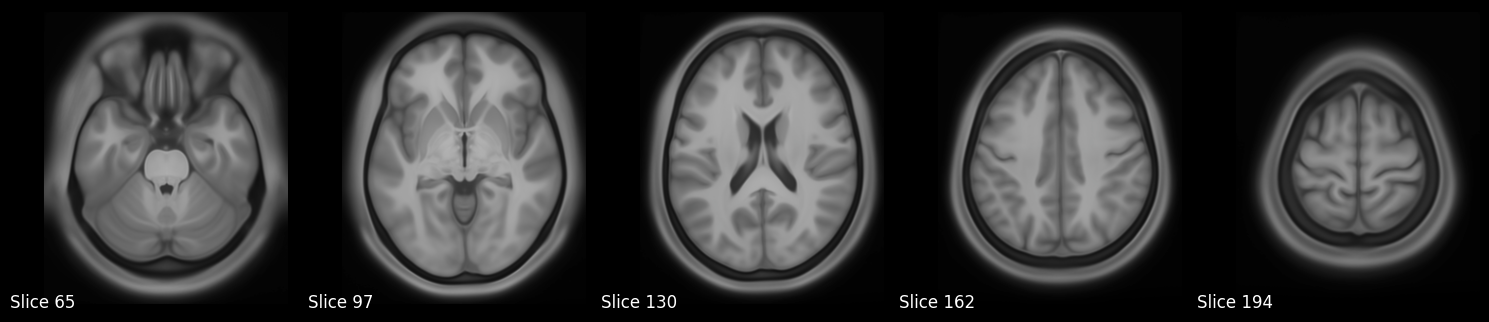

In [4]:
visualize_multiple_axial_slices(f"{working_directory}/data/S1200_AverageT1w_restore.nii.gz")

In [5]:
def axial_volume_slice_render_nifti_with_overlay(img_ras, overlay_ras, slice_index, overlay_threshold, ax, cmap=cc.cm.gray, clims=None, overlay_cmap=cc.cm.fire, overlay_alpha=0.9, overlay_clim=None):
    """
    Render a single slice from a 3D NIfTI volume.

    Parameters:
    - img: NIfTI image loaded by nibabel in the RAS+ space.
    - slice_index: int, index of the slice to render.
    - cmap: str, colormap to use for rendering.
    - clims: tuple, the min and max value of the color range.
    - ax: matplotlib axis to render the slice on.
    - overlay_ras: NIfTI image loaded by nibabel in the RAS+ space for the overlay.
    - overlay_threshold: float, threshold for the overlay data.
    - overlay_cmap: str, colormap to use for the overlay.
    - overlay_alpha: float, transparency level for the overlay.
    - overlay_clim: tuple, the min and max value of the color range for the overlay.
    """
    # Get the image data
    data = img_ras.get_fdata()
    overlay_data = overlay_ras.get_fdata()

    # Apply the overlay threshold
    overlay_data[overlay_data < overlay_threshold] = np.nan  # Set values below the threshold to NaN

    # Check if the slice index is valid
    if slice_index < 0 or slice_index >= data.shape[2]:
        raise ValueError("Slice index out of bounds.")

    # Extract the specified slice
    slice_data = data[:, :, slice_index]
    overlay_slice = overlay_data[:, :, slice_index]

    # Plot the slice
    im = ax.imshow(slice_data.T, cmap=cmap, origin='lower')

    # Apply clim if given
    if clims:
        im.set_clim(*clims)

    # Before plotting the overlay, set the colormap's bad color to transparent
    overlay_cmap = overlay_cmap.copy()  # Make a copy to avoid modifying the global colormap
    overlay_cmap.set_bad(color=(0, 0, 0, 0))  # RGBA, alpha=0 for transparency


    # Overlay the data
    om = ax.imshow(overlay_slice.T, cmap=overlay_cmap, alpha=overlay_alpha, origin='lower')

    # Apply overlay clim if given
    if overlay_clim:
        om.set_clim(*overlay_clim)

    ax.axis('off')

def visualize_multiple_axial_slices_with_overlay(nifti_file, overlay_file, slice_indices=5, cmap=cc.cm.gray, overlay_cmap=cc.cm.fire, figsize=(15, 4)):
    """
    Visualize multiple axial slices from a 3D NIfTI volume, while also displaying an overlay image on top.

    Parameters:
    - img: NIfTI image file path.
    - slice_indices: int, number of slices to render.
    - cmap: str, colormap to use for rendering.
    - clims: tuple, the min and max value of the color range.
    - overlay_file: NIfTI image file path for the overlay.
    - figsize: tuple, size of the matplotlib figure.
    - overlay_cmap: str, colormap to use for the overlay.

    Note: This function assumes that the overlay image is in the same dimension as the main image.
    """
    # Load NIfTI images with nibabel
    img = nib.load(nifti_file)
    overlay = nib.load(overlay_file)

    # Reorient to RAS+ space
    img_ras = nib.as_closest_canonical(img)
    overlay_ras = nib.as_closest_canonical(overlay)

    # Get total number of axial slices
    total_slices = img_ras.shape[2]

    # Sample evenly spaced indices, avoiding edges
    selected_slices = np.linspace(0, total_slices - 1, slice_indices + 4)[2:-2]
    selected_slices = np.round(selected_slices).astype(int)

    # Define an overlay threshold as the 80th percentile in the data
    overlay_threshold = np.percentile(overlay_ras.get_fdata().ravel(), 80)

    # Define color limits
    clims = (img_ras.get_fdata().min(), img_ras.get_fdata().max())
    overlay_clims = (overlay_threshold, overlay_ras.get_fdata().max())

    # Create the figure
    fig, axs = plt.subplots(1, slice_indices, figsize=figsize)
    for ax, slice_index in zip(axs, selected_slices):
        axial_volume_slice_render_nifti_with_overlay(img_ras, overlay_ras, slice_index, overlay_threshold=overlay_threshold, ax=ax, cmap=cmap, clims=clims, overlay_cmap=overlay_cmap, overlay_clim=overlay_clims)

        # add text to show axial slice index
        ax.text(0.5, 0.5, f"Slice {slice_index}", color='white', fontsize=12, ha='center', va='center')

    # set plot background to black
    fig.patch.set_facecolor('black')
    for ax in axs:
        ax.set_facecolor('black')

    # set tight layout
    plt.tight_layout()
    plt.show()


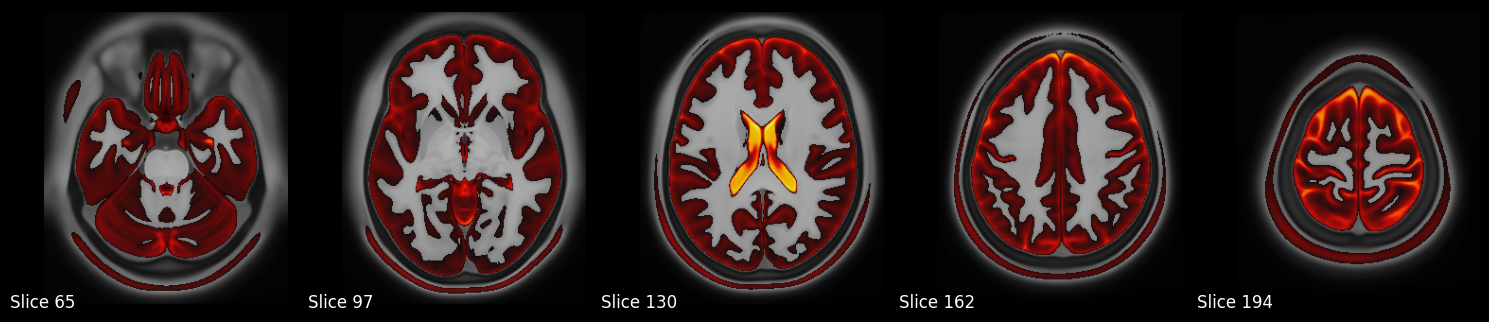

In [6]:
# Visualize T1 weighted image, and overlay T2w on top of it
visualize_multiple_axial_slices_with_overlay(
    f"{working_directory}/data/S1200_AverageT1w_restore.nii.gz",
    f"{working_directory}/data/S1200_AverageT2w_restore.nii.gz"
)


### Surface-based Visualizations

In the examples below, we will work with surface-based data from the Human Connectome Project’s [**S1200 Group Average Data Release**](https://www.humanconnectome.org/study/hcp-young-adult/article/s1200-group-average-data-release), specifically using the fsLR template surface coordinates.

We’ll visualize the average cortical curvature mapped onto the cortical surface to highlight anatomical landmarks and folding patterns.


In [7]:
# Brain visualizations with Cerebro

# basic parameters
surface = 'inflated'
expand = 0

# load an example dscalar
dscalar_file = cbu.cifti_template_file
dscalar = nib.load(dscalar_file)

# read the brain models from the dscalar header
brain_models = [x for x in dscalar.header.get_index_map(1).brain_models]

# load surfaces for visualization
left_surface_file, right_surface_file = cbu.get_left_and_right_GIFTI_template_surface(surface)
left_surface = nib.load(left_surface_file)
right_surface = nib.load(right_surface_file)

# extract surface information
lx, ly, lz = left_surface.darrays[0].data.T
lt = left_surface.darrays[1].data
rx, ry, rz = right_surface.darrays[0].data.T
rt = right_surface.darrays[1].data

# combine into a complete brain
lrx = np.concatenate([lx - expand, rx + expand])
lry = np.concatenate([ly, ry])
lrz = np.concatenate([lz, rz])
lrt = np.concatenate([lt, (rt + lx.shape[0])])

lxyz = left_surface.darrays[0].data
rxyz = right_surface.darrays[0].data
lrxyz = np.array([lrx, lry, lrz]).T

# create a mapping between surface and cifti vertices
left_cortical_surface_model, right_cortical_surface_model = brain_models[0], brain_models[1]
cifti_to_surface = {}
surface_to_cifti = {}
for (i, x) in enumerate(left_cortical_surface_model.vertex_indices):
    cifti_to_surface[i] = x
    surface_to_cifti[x] = i
for (i, x) in enumerate(right_cortical_surface_model.vertex_indices):
    cifti_to_surface[i + right_cortical_surface_model.index_offset] = x + rx.shape[0]
    surface_to_cifti[x + rx.shape[0]] = i + right_cortical_surface_model.index_offset

# construct data over surface
surface_mask = list(surface_to_cifti.keys())


# ignore warning when loading cifti
nib.imageglobals.logger.setLevel(40)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec

# Function to plot a single view of the brain using Cerebro
def plot_single_view_with_cerebro(dscalar_data, ax, colormap=plt.cm.coolwarm, clims=None, vlims=None, exclusion_color=(1.,1.,1.,0), view="L", show_colorbar=False, colorbar_format=None, cifti_left_right_seperation=0, surface = 'midthickness'):
    """
    Plot a single view of the brain using Cerebro.

    Parameters:
    - dscalar_data: numpy array, data to be visualized on the brain surface.
    - ax: matplotlib axis to render the brain view on.
    - colormap: colormap to use for the data.
    - clims: tuple, color limits for the data.
    - vlims: tuple, value limits for the data.
    - exclusion_color: color to use for excluded data points.
    - view: tuple, camera view configuration for the brain viewer.
    - show_colorbar: bool, whether to show the colorbar.
    - colorbar_format: str, format for the colorbar ticks.
    - cifti_left_right_seperation: int, separation distance for left and right hemispheres.
    - surface: str, type of fs-LR surface to use for visualization (e.g., 'midthickness', 'inflated').
    """
    try:

        my_brain_viewer = cbv.Cerebro_brain_viewer(offscreen=True, background_color=(1.,1.,1.,0), null_color=(1., 1., 1., 0.0), no_color=(0.7, 0.7, 0.7, 1.))

        surface_model = my_brain_viewer.load_template_GIFTI_cortical_surface_models(surface)

        cifti_space = my_brain_viewer.visualize_cifti_space(
            volumetric_structures='none', cifti_left_right_seperation=cifti_left_right_seperation,
        )

        dscalar_layer = my_brain_viewer.add_cifti_dscalar_layer(
            dscalar_data=dscalar_data,
            colormap=colormap,
            clims=clims,
            vlims=vlims,
            exclusion_color=exclusion_color,
            opacity=0.95)

        ax.axis('off')
        camconf = my_brain_viewer._view_to_camera_config(view)
        # camconf = my_brain_viewer.zoom_camera_to_content(camconf)
        my_brain_viewer.viewer.change_view(**camconf)
        my_brain_viewer.offscreen_draw_to_matplotlib_axes(ax)

    finally:
        my_brain_viewer.viewer.window.destroy()

def plot_left_right_surface_with_cerebro(dscalar_data, fig, ax, colormap=plt.cm.coolwarm, clims=None, show_colorbar=False, colorbar_format=None, **kwargs):
    # Hide the parent axis
    ax.set_visible(False)

    # Create a 2x2 GridSpec within the axis using inset_axes
    gs = ax.inset_axes([0, 0, 1, 1], transform=ax.transAxes)
    sub_gs = GridSpec(2, 2, gs, hspace=0., wspace=0.)

    # Create a 4x4 grid
    ax_tl = fig.add_subplot(sub_gs[0, 0])
    ax_tr = fig.add_subplot(sub_gs[0, 1])
    ax_bl = fig.add_subplot(sub_gs[1, 0])
    ax_br = fig.add_subplot(sub_gs[1, 1])
    
    # separate data to left and right
    dscalar_data_left = dscalar_data.copy()
    dscalar_data_left[left_cortical_surface_model.index_count:] = np.nan
    dscalar_data_right = dscalar_data.copy()
    dscalar_data_right[:left_cortical_surface_model.index_count] = np.nan
    
    # Lateral left view
    plot_single_view_with_cerebro(dscalar_data_left, ax_tl, colormap=colormap, clims=clims,
                                  view=((-420, 0, 0), None, None, None), **kwargs)
    # Medial left view
    plot_single_view_with_cerebro(dscalar_data_left, ax_bl, colormap=colormap, clims=clims,
                                  view=((420, 0, 0), None, None, None), cifti_left_right_seperation=-80, **kwargs)
    
    # Lateral right view
    plot_single_view_with_cerebro(dscalar_data_right, ax_tr, colormap=colormap, clims=clims,
                                  view=((420, 0, 0), None, None, None), **kwargs)
    # Medial right view
    plot_single_view_with_cerebro(dscalar_data_right, ax_br, colormap=colormap, clims=clims,
                                  view=((-420, 0, 0), None, None, None), cifti_left_right_seperation=-80, **kwargs)

    if show_colorbar:
        cax = inset_axes(
            ax,
            width="30%",
            height="4%",
            loc="center",
            bbox_to_anchor=(-0., 0.0, 1., 1.),
            bbox_transform=ax.transAxes,
            borderpad=0,
        )
        cb = fig.colorbar(
            mpl.cm.ScalarMappable(
                norm=mpl.colors.Normalize(vmin=clims[0], vmax=clims[1]),
                cmap=colormap
            ),
            cax=cax,
            aspect=10,
            orientation='horizontal',
            format=colorbar_format,
        )
        cb.outline.set_visible(False)
        cb.ax.tick_params(labelsize=12)
        cb.ax.tick_params(length=0)


In [8]:
def suppress_c_output():
    """Suppress low-level C output by redirecting stdout and stderr to /dev/null."""
    devnull = os.open(os.devnull, os.O_WRONLY)
    old_stdout = os.dup(1)
    old_stderr = os.dup(2)
    os.dup2(devnull, 1)
    os.dup2(devnull, 2)
    os.close(devnull)
    return old_stdout, old_stderr

def restore_c_output(old_stdout, old_stderr):
    """Restore the original stdout and stderr."""
    os.dup2(old_stdout, 1)
    os.dup2(old_stderr, 2)
    os.close(old_stdout)
    os.close(old_stderr)

def plot_dscalar_with_cerebro(dscalar_file, fig, ax, **kwargs):
    """
    Plot a dscalar file using Cerebro's brain viewer.

    Parameters:
    - dscalar_file: str, path to the dscalar file.
    - ax: matplotlib axis to render the plot on.
    - kwargs: additional keyword arguments for the plot.
    """
    dscalar_data = nib.load(dscalar_file).get_fdata()[0]
    clims = (dscalar_data.min(), dscalar_data.max())

    # Suppress low-level output
    old_stdout, old_stderr = suppress_c_output()

    try:
        # Plot the left and right surfaces with Cerebro
        plot_left_right_surface_with_cerebro(
            dscalar_data, fig=fig, ax=ax, clims=clims, **kwargs
        )
    finally:
        # Restore the original stdout and stderr
        restore_c_output(old_stdout, old_stderr)

    plt.show()

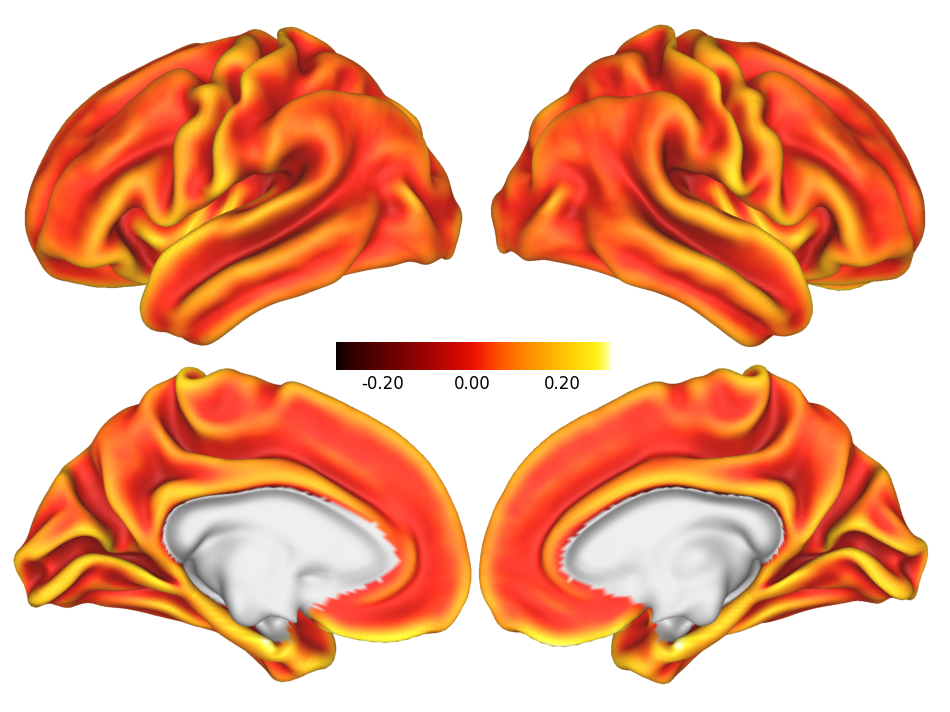

In [9]:
# Plot curvature dscalar file in gray scale
dscalar_file = f"{working_directory}/data/S1200.curvature_MSMAll.32k_fs_LR.dscalar.nii"

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(12, 9))

# Plot the dscalar file with Cerebro
plot_dscalar_with_cerebro(dscalar_file, fig=fig, ax=ax, colormap=cc.cm.fire, show_colorbar=True, colorbar_format='%.2f')


### Volume-to-Surface Transformation

In this example, we demonstrate how to perform a volume-to-surface transformation using the [Melbourne Subcortical Atlas](https://github.com/yetianmed/subcortex), specifically from its Scale 1 parcellation (available from [`Tian_Subcortex_S1_3T.nii.gz`](https://github.com/yetianmed/subcortex/tree/master/Group-Parcellation/3T/Subcortex-Only)).

We will generate and render a separate cortical surface visualization for each labeled region in the atlas.

This transformation and rendering will be performed using tools from the **Cerebro Brain Viewer**, which provides convenient functionality for mapping volumetric data onto surface meshes.


In [10]:
# Function to plot a single view of a glass brain using Cerebro
def plot_glass_brain_and_atlas_with_cerebro(ax, atlas_file, view="L", surface='midthickness', glass_color=(0.5, 0.5, 0.5, 0.5)):
    """
    Plot a single view of the brain with an atlas volume to surface transformation using Cerebro.

    Parameters:
    - ax: matplotlib axis to render the brain view on.
    - atlas_file: str, path to the atlas file (NIfTI format).
    - view: tuple, camera view configuration for the brain viewer.
    - glass_color: tuple, color for the glass brain overlay.
    - surface: str, type of fs-LR surface to use for visualization (e.g., 'midthickness', 'inflated').
    """
    try:

        my_brain_viewer = cbv.Cerebro_brain_viewer(offscreen=True, background_color=(1.,1.,1.,0), null_color=glass_color, no_color=(0.7, 0.7, 0.7, 1.))

        surface_model = my_brain_viewer.load_template_GIFTI_cortical_surface_models(surface)

        # visualize the glass brain
        cifti_space = my_brain_viewer.visualize_cifti_space(
            volumetric_structures='none',
        )

        # Now, process the atlas file
        atlas_img = nib.load(atlas_file)
        atlas_data = atlas_img.get_fdata()

        # Extract atlas labels except for zero (background)
        atlas_labels = [x for x in np.unique(atlas_data) if x != 0]

        # Create a directory to store temporary binary masks
        temp_masks_dir = "data/temp_masks"
        os.makedirs(temp_masks_dir, exist_ok=True)

        # Visualize the atlas labels in the glass brain
        for label in atlas_labels:
            # Store binary masks for each atlas label
            mask = (atlas_data == label).astype(np.float32)
            mask_img = nib.Nifti1Image(mask, atlas_img.affine)
            mask_file = f"{temp_masks_dir}/atlas_label_{label}.nii.gz"
            nib.save(mask_img, mask_file)

            # Get a color for the mask from a colormap with randomness
            color = plt.cm.prism((label - 1) / len(atlas_labels))
            # color = cc.cm.rainbow((label - 1) / len(atlas_labels))

            # Add the mask as a layer in the brain viewer
            my_brain_viewer.visualize_mask_surface(
                mask_file,  # The volumetric file
                0.7,  # A threshold to mask the binary data
                color=color,  # Use the colormap color
                gradient_direction="ascent",  # This defines the surface normal directions
                smoothing=200,  # Iteratively smooth the surface to look better
                smoothing_filter="taubin",  # Type of smoothing filter to use
            )
        
        # Delete the temporary masks directory after use
        for mask_file in os.listdir(temp_masks_dir):
            os.remove(os.path.join(temp_masks_dir, mask_file))
        os.rmdir(temp_masks_dir)

        ax.axis('off')
        camconf = my_brain_viewer._view_to_camera_config(view)
        # camconf = my_brain_viewer.zoom_camera_to_content(camconf)
        my_brain_viewer.viewer.change_view(**camconf)
        my_brain_viewer.offscreen_draw_to_matplotlib_axes(ax)

    finally:
        my_brain_viewer.viewer.window.destroy()

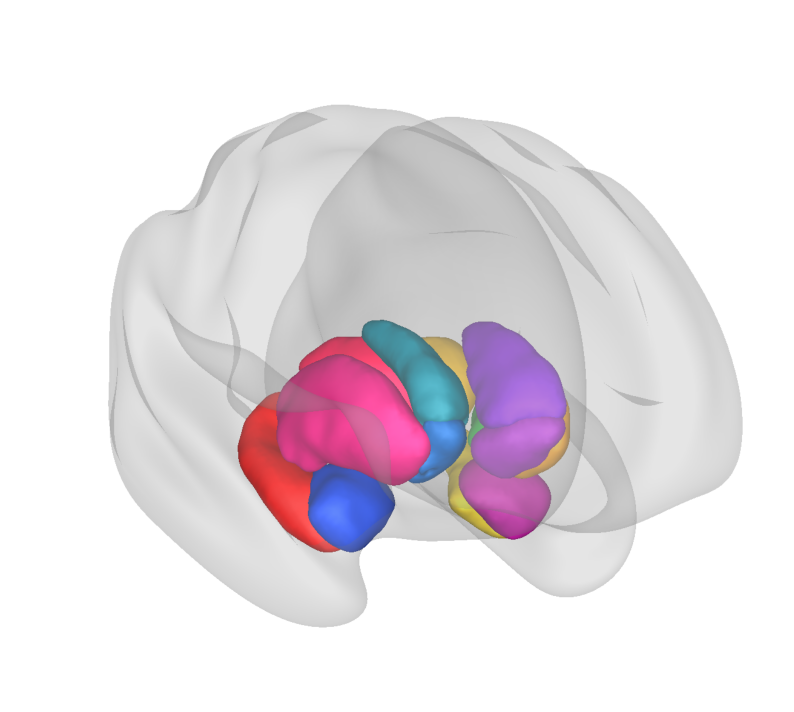

In [11]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 9))

# Suppress low-level output
old_stdout, old_stderr = suppress_c_output()

try:
    # Plot the glass brain with the subcortical atlas
    plot_glass_brain_and_atlas_with_cerebro(
        ax=ax, atlas_file="data/Tian_Subcortex_S1_3T.nii.gz", view=((250, 350, 0), None, None, None), surface='inflated', glass_color=(0.9, 0.9, 0.9, 0.2)
    )
finally:
    # Restore the original stdout and stderr
    restore_c_output(old_stdout, old_stderr)


### Tractography Visualization

In this section, we will visualize tractography data from the [ORG fiber clustering atlas](https://github.com/SlicerDMRI/ORG-Atlases?tab=readme-ov-file). We will render a single fiber bundle using the Cerebro Brain Viewer, showcasing how to load and display streamline data effectively.


In [12]:
# Function to plot a single view of a glass brain using Cerebro
def plot_glass_brain_and_tractography_with_cerebro(ax, tract_file, view="L", surface='midthickness', glass_color=(0.5, 0.5, 0.5, 0.5), maximum_streamlines=100):
    """
    Plot a single view of the brain with an atlas volume to surface transformation using Cerebro.

    Parameters:
    - ax: matplotlib axis to render the brain view on.
    - tract_file: str, path to the tractography file (tck format).
    - view: tuple, camera view configuration for the brain viewer.
    - glass_color: tuple, color for the glass brain overlay.
    - surface: str, type of fs-LR surface to use for visualization (e.g., 'midthickness', 'inflated').
    """
    try:

        my_brain_viewer = cbv.Cerebro_brain_viewer(offscreen=True, background_color=(1.,1.,1.,0), null_color=glass_color, no_color=(0.7, 0.7, 0.7, 1.))

        surface_model = my_brain_viewer.load_template_GIFTI_cortical_surface_models(surface)

        # visualize the glass brain
        cifti_space = my_brain_viewer.visualize_cifti_space(
            volumetric_structures='none',
        )

        # Now, process the tractography file
        tractography = nib.streamlines.load(tract_file)

        # sample at most maximum_streamlines streamlines for visualization
        if len(tractography.streamlines) > maximum_streamlines:
            selected_streamlines = tractography.streamlines[np.random.choice(len(tractography.streamlines), maximum_streamlines, replace=False)]
        else:
            selected_streamlines = tractography.streamlines

        # for each streamline, visualize it with cylinders
        for streamline in selected_streamlines:
            # make pairs of consecutive points in the streamline
            line_coordinates = np.stack([streamline[:-1], streamline[1:]], axis=1) # shape (N, 2, 3)

            # get a symmetric color gradient for the streamline
            color_gradient = np.linspace(-1, 1, line_coordinates.shape[0])**2
            color = cc.cm.rainbow(color_gradient)  # Use a colormap to get colors for the streamline

            # visualize the streamline as a cylinder
            my_brain_viewer.visualize_cylinders(line_coordinates, radii=0.2, color=color)

        ax.axis('off')
        camconf = my_brain_viewer._view_to_camera_config(view)
        # camconf = my_brain_viewer.zoom_camera_to_content(camconf)
        my_brain_viewer.viewer.change_view(**camconf)
        my_brain_viewer.offscreen_draw_to_matplotlib_axes(ax)

    finally:
        my_brain_viewer.viewer.window.destroy()

Text(0.5, 0.95, 'Tractography Streamlines (SLF-III)')

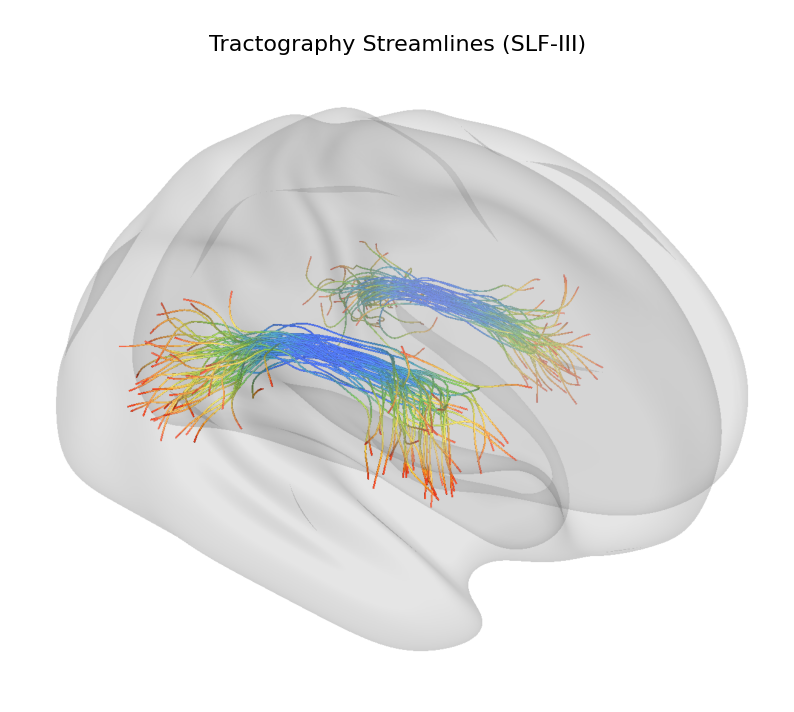

In [13]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 9))

# Suppress low-level output
old_stdout, old_stderr = suppress_c_output()

try:
    # Plot the glass brain with the subcortical atlas
    plot_glass_brain_and_tractography_with_cerebro(
        ax=ax, # axis to render the brain view on
        tract_file="data/T_SLF-III-cluster_00209.tck", # path to the tractography file
        view=((400, 150, 100), None, None, None), # camera view configuration for the brain viewer (a view from the right side, slightly tilted towards the frontal superior part of the brain)
        surface='inflated', glass_color=(0.9, 0.9, 0.9, 0.2)
    )
finally:
    # Restore the original stdout and stderr
    restore_c_output(old_stdout, old_stderr)

# Add text to the plot
ax.text(0.5, 0.95, "Tractography Streamlines (SLF-III)", transform=ax.transAxes, fontsize=16, ha='center', va='center', color='black')

### Brain Network Visualizations

This example uses functional human connectome data from {footcite:t}`mansour2021high`. We will visualize both a connectivity heatmap and a 3D brain network derived from an individual’s functional connectome, mapped onto the HCP MMP1 atlas ({footcite:t}`glasser2016multi`).

The connectivity heatmap will be created using **Matplotlib**, while the 3D brain network visualization will be generated with the **Cerebro Brain Viewer**.


In [14]:
# load the HCP MMP1 atlas
glasser_atlas_file = f"{working_directory}/data/Glasser_Atlas.32k_fs_LR.dlabel.nii"
glasser_atlas = nib.load(glasser_atlas_file)

# Load individual's functional connectivity matrix
fc_matrix_file = f"{working_directory}/data/100206_test_functional_connectivity_glasser.npy"
fc_matrix = np.load(fc_matrix_file)

# Load the label names associated with the rows and columns of the functional connectivity matrix
label_names_file = f"{working_directory}/data/glasser_atlas_labels.json"
with open(label_names_file, 'r') as f:
    label_names = json.load(f)
label_indices_lookup = {label_names[i]: i for i in label_names}

# Get label orders from glasser atlas
glasser_atlas_labels_dict = glasser_atlas.header.get_axis(0).label[0]

# Reorder the functional connectivity matrix according to the glasser atlas labels
fc_reordering_permutation = [int(label_indices_lookup[glasser_atlas_labels_dict[x][0]]) for x in range(1, max(glasser_atlas_labels_dict.keys()) + 1)]
fc_matrix_reordered = fc_matrix[fc_reordering_permutation, :][:, fc_reordering_permutation]


Text(0.5, 1.0, 'Functional Connectivity Matrix (Glasser Atlas)')

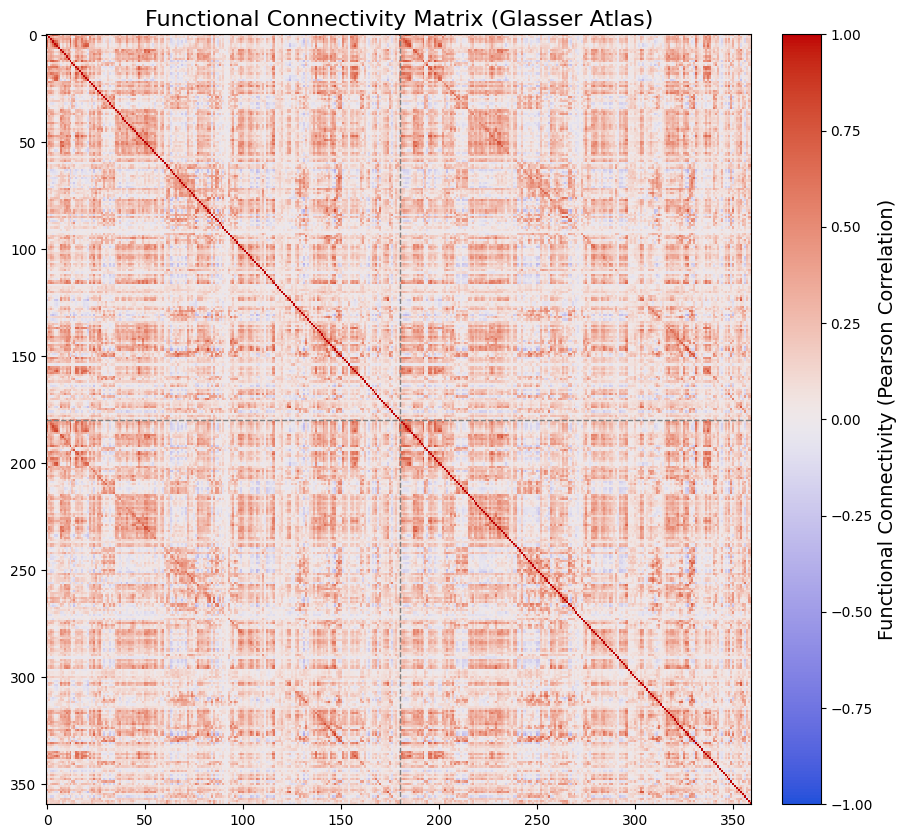

In [15]:
# Get a figure and axis for the heatmap
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the heatmap of the functional connectivity matrix
im = ax.imshow(fc_matrix_reordered, cmap=cc.cm.coolwarm, aspect='auto', interpolation='nearest', vmin=-1, vmax=1)

# Set the ticks and labels for the heatmap
glasser_label_names = [glasser_atlas_labels_dict[x][0] for x in range(1, max(glasser_atlas_labels_dict.keys()) + 1)]

# Add a dashed line at the middle of the heatmap to separate left and right hemispheres
ax.axvline(x=len(glasser_label_names)//2, color='gray', linestyle='--', linewidth=1)
ax.axhline(y=len(glasser_label_names)//2, color='gray', linestyle='--', linewidth=1)

# Add a colorbar to the heatmap
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.05, pad=0.04)
cbar.set_label('Functional Connectivity (Pearson Correlation)', fontsize=14)

# Set the title for the heatmap
ax.set_title("Functional Connectivity Matrix (Glasser Atlas)", fontsize=16)


In [16]:
# Function to plot a 3D brain network using Cerebro
def plot_glass_brain_and_network_with_cerebro(ax, adjacency_matrix, node_coords, node_radii=2, node_colors=(0., 0., 0.), edge_radii=1, view="L", surface='midthickness', glass_color=(0.5, 0.5, 0.5, 0.5), maximum_streamlines=100):
    """
    Plot a single view of the brain with an atlas volume to surface transformation using Cerebro.

    Parameters:
    - ax: matplotlib axis to render the brain view on.
    - adjacency_matrix: 2D array, the adjacency matrix representing the brain network.
    - node_coords: 2D array, the coordinates of the nodes in the brain network.
    - view: tuple, camera view configuration for the brain viewer.
    - glass_color: tuple, color for the glass brain overlay.
    - surface: str, type of fs-LR surface to use for visualization (e.g., 'midthickness', 'inflated').
    """
    try:

        my_brain_viewer = cbv.Cerebro_brain_viewer(offscreen=True, background_color=(1.,1.,1.,0), null_color=glass_color, no_color=(0.7, 0.7, 0.7, 1.))

        surface_model = my_brain_viewer.load_template_GIFTI_cortical_surface_models(surface)

        # visualize the glass brain
        cifti_space = my_brain_viewer.visualize_cifti_space(
            volumetric_structures='none',
        )

        # Reformat edge radii
        if edge_radii.shape == adjacency_matrix.shape:
            sparse_adjacency = sparse.coo_matrix(adjacency_matrix)
            edge_list = np.array([sparse_adjacency.row, sparse_adjacency.col]).T
            edge_radii = edge_radii[edge_list[:, 0], edge_list[:, 1]]  # Get edge radii corresponding to the edges in the adjacency matrix
            edge_colors = cc.cm.fire(np.clip((edge_radii - edge_radii.min()) / (edge_radii.max() - edge_radii.min()), 0, 1))  # Use a colormap to get colors for the edges
            print(edge_radii.shape, edge_list.shape, edge_colors.shape)
        else:
            edge_colors = (0.8, 0.2, 0.2, 1.)  # Default edge color if radii are not provided

        # Visualize the brain network
        my_brain_viewer.visualize_network(
            adjacency=adjacency_matrix,  # The adjacency matrix of the network
            node_coordinates=node_coords,  # The coordinates of the nodes in the network
            node_color=node_colors,  # The colors of the nodes in the network
            node_radii=node_radii,  # The radii of the nodes in the network
            edge_radii=edge_radii,  # The radii of the edges in the network
            edge_color=edge_colors,  # The colors of the edges in the network
        )

        ax.axis('off')
        camconf = my_brain_viewer._view_to_camera_config(view)
        # camconf = my_brain_viewer.zoom_camera_to_content(camconf)
        my_brain_viewer.viewer.change_view(**camconf)
        my_brain_viewer.offscreen_draw_to_matplotlib_axes(ax)

    finally:
        my_brain_viewer.viewer.window.destroy()

(206,) (206, 2) (206, 4)


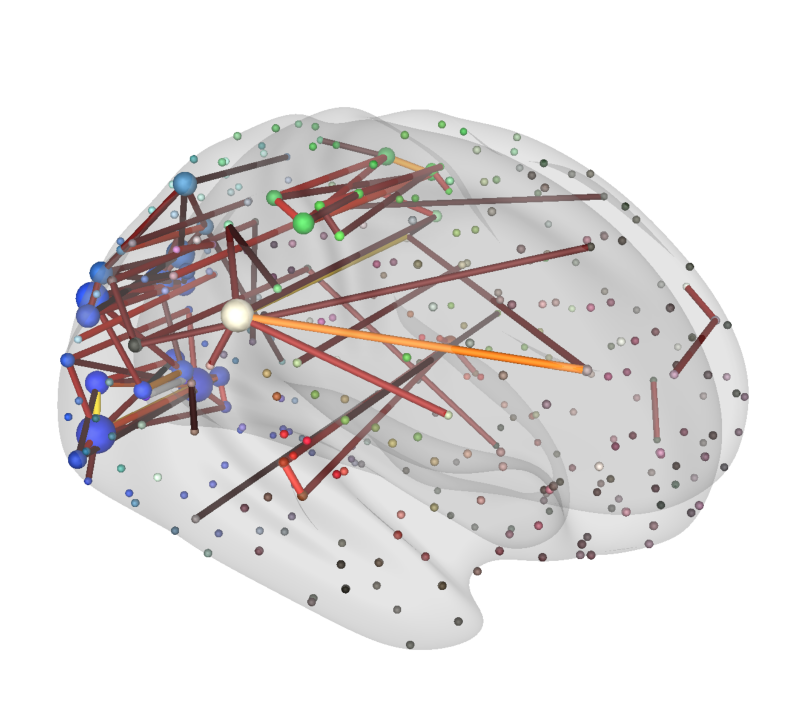

In [17]:
# Now that we have the functional connectivity matrix,
# we need the coordinates of the nodes in the glasser atlas
node_coords = np.array([lrxyz[surface_mask][glasser_atlas.get_fdata()[0] == x].mean(axis=0) for x in range(1, max(glasser_atlas_labels_dict.keys())+1)])

# Let's also extract node colors from the glasser atlas
glasser_label_colors = [glasser_atlas_labels_dict[x][1] for x in range(1, max(glasser_atlas_labels_dict.keys()) + 1)]

# Now let's threshold the functional connectivity matrix to only keep the strongest connections
threshold = 0.7  # threshold for the functional connectivity matrix
fc_matrix_thresholded = np.where(np.abs(fc_matrix_reordered) > threshold, fc_matrix_reordered, 0)
# also remove self-connections
np.fill_diagonal(fc_matrix_thresholded, 0)

# Node sizes can be set based on the degree of each node
node_degrees = np.sum(np.abs(fc_matrix_thresholded), axis=1)
node_radii = np.clip(node_degrees / np.max(node_degrees) * 5, 1, 5)  # Scale node sizes between 1 and 5
node_radii = np.repeat(node_radii[:, np.newaxis], 3, axis=1) # Make node radii along 3 dimensions (N x 3)

# Edge radii can be set based on the strength of the connections
edge_radii = np.clip(np.abs(fc_matrix_thresholded) / np.max(np.abs(fc_matrix_thresholded)), 0.2, 1)  # Scale edge sizes between 0.2 and 1

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 9))

# Suppress low-level output
old_stdout, old_stderr = suppress_c_output()

try:
    # Plot the glass brain with the subcortical atlas
    plot_glass_brain_and_network_with_cerebro(
        ax=ax, # axis to render the brain view on
        adjacency_matrix=fc_matrix_thresholded,  # The adjacency matrix of the network
        node_coords=node_coords,  # The coordinates of the nodes in the network
        node_colors=glasser_label_colors,  # The colors of the nodes in the network
        node_radii=node_radii,  # The radii of the nodes in the network
        edge_radii=edge_radii,  # The radii of the edges in the network
        view=((400, 150, 100), None, None, None), # camera view configuration for the brain viewer (a view from the right side, slightly tilted towards the frontal superior part of the brain)
        surface='inflated', glass_color=(0.9, 0.9, 0.9, 0.2)
    )
finally:
    # Restore the original stdout and stderr
    restore_c_output(old_stdout, old_stderr)




---


## 📑 References

```{footbibliography}
```
